# Machine Learning Models For Motion Intention Using EMG Signals

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
import math
from utils import *

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.feature_selection as fs

import keras
import tensorflow as tf
from keras.models import load_model

In [2]:
keras.backend.clear_session()
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


## Load Data

In [3]:
w_length = 200
w_increment = 100

path = 'D:\Documentos\Datasets\Grabaciones 1'

raw_data = loadRawData(path, w_length, w_increment)

AT_FE1.txt
AT_FE2.txt
AT_FE3.txt
AT_FE4.txt
AT_FE_EC1.txt
AT_FE_EC2.txt
AT_FE_FC1.txt
AT_FE_FC2.txt
AT_PS1.txt
AT_PS2.txt
AT_PS3.txt
AT_PS4.txt
AT_PS5.txt
AT_PS_PC1.txt
AT_PS_PC2.txt
AT_PS_SC1.txt
AT_PS_SC2.txt
JT_FE1.txt
JT_FE2.txt
JT_FE_EC1.txt
JT_FE_EC2.txt
JT_FE_FC1.txt
JT_FE_FC2.txt
JT_PS1.txt
JT_PS2.txt
JT_PS_PC1.txt
JT_PS_PC2.txt
JT_PS_SC1.txt
JT_PS_SC2.txt
SV_FE1.txt
SV_FE2.txt
SV_FE3.txt
SV_FE4.txt
SV_FE_EC1.txt
SV_FE_EC2.txt
SV_FE_FC1.txt
SV_FE_FC2.txt
SV_PS1.txt
SV_PS2.txt
SV_PS_PC1.txt
SV_PS_PC2.txt
SV_PS_SC1.txt
SV_PS_SC2.txt
Y_FE1.txt
Y_FE2.txt
Y_FE_EC1.txt
Y_FE_EC2.txt
Y_FE_FC1.txt
Y_FE_FC2.txt
Y_PS1.txt
Y_PS2.txt
Y_PS_PC1.txt
Y_PS_PC2.txt
Y_PS_SC1.txt
Y_PS_SC2.txt


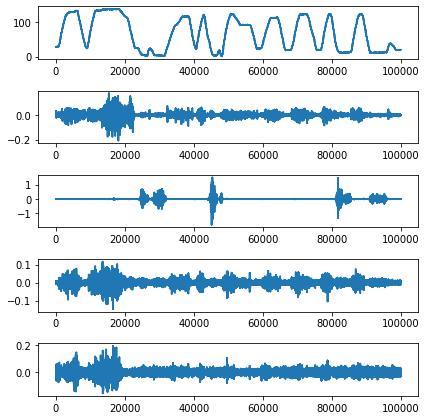

In [4]:
fig, axs = plt.subplots(5, figsize=(6,6))
fig.tight_layout()
plot_data = np.vstack(raw_data)

n = 100000

axs[0].plot(plot_data[0:n,4])
axs[1].plot(plot_data[0:n,0])
axs[2].plot(plot_data[0:n,1])
axs[3].plot(plot_data[0:n,2])
axs[4].plot(plot_data[0:n,3])

In [5]:
w, c = raw_data[0].shape
ch = c - 1
print('Number of examples (m) = ', len(raw_data))
print('Window lenght (w) = ', w)
print('Number of EMG channels (ch) = ', ch)

Number of examples (m) =  12408
Window lenght (w) =  200
Number of EMG channels (ch) =  4


In [6]:
emg_raw_arr = np.array(raw_data)[:,:,0:4]
print(emg_raw_arr.shape)

(12408, 200, 4)


## EMG Features

In [7]:
f_emg_data = EMGfeatures(emg_raw_arr)

sc = MinMaxScaler()
trans = sc.fit_transform(f_emg_data)

print(f_emg_data.shape)

c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


(12408, 44)


## Moving Average Filter

In [7]:
maf_emg_data = maf(emg_raw_arr)

ascol = maf_emg_data.reshape(-1, ch)
sc = MinMaxScaler()
trans = sc.fit_transform(ascol)

maf_emg_data = trans.reshape(-1, w, ch)
print(maf_emg_data.shape)

(12408, 200, 4)


## Autoencoder Feature Extraction

In [17]:
cnn_encoder = load_model('encoder_model.h5')
cnn_encoder.summary()

Model: "Convolutional_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 200, 4, 16)        272       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 100, 2, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 2, 8)         520       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 1, 8)         0         
 2D)                                                             
                                                                 
Total params: 792
Trainable params: 792
Non-trainable params: 0
_________________________________________________________________


In [18]:
cnn_encoder.compile(optimizer='adam', loss='binary_crossentropy')
ae_emg = cnn_encoder.predict(emg_raw_arr)
print(ae_emg.shape)
ae_emg = ae_emg.reshape(ae_emg.shape[0], -1)
print(ae_emg.shape)

388/388 [==============================] - 6s 2ms/step
(12408, 50, 1, 8)
(12408, 400)


## Data Split

# Classifiers Training

## EMG Features

In [ ]:
nb = GaussianNB()
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()
lda = LinearDiscriminantAnalysis()
lr = LogisticRegression(max_iter=500)
mlp = MLPClassifier(max_iter=500)
svm = SVC()
bg = BaggingClassifier()
ab = AdaBoostClassifier()
gb = GradientBoostingClassifier()
rf = RandomForestClassifier()
clfs = [
       ('nb', GaussianNB()),
       ('dt', DecisionTreeClassifier())
]
st = StackingClassifier(clfs, final_estimator=LogisticRegression())

models_names_classif = ['Naive Bayes', 'Decision Tree', 'KNN', 'LDA', 'Logistic Regression', 'MLP', 'SVM', 'Bagging', 'AdaBoost', 
                'Gradient Boosting', 'Random Forest', 'Stacking']
models_classif = [nb, dt, knn, lda, lr, mlp, svm, bg, ab, gb, rf, st]

In [ ]:
train_scores, test_scores, cms = cvClassifiers(X_train, Y_train, models_classif, k=10)

In [ ]:
for i, cm in enumerate(cms):
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  disp.plot()
  disp.ax_.set_title(models_names_classif[i], fontSize=16)
  plt.grid(False)

## Moving Average Filter

In [ ]:
nb = GaussianNB()
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()
lda = LinearDiscriminantAnalysis()
lr = LogisticRegression(max_iter=500)
mlp = MLPClassifier(max_iter=500)
svm = SVC()
bg = BaggingClassifier()
ab = AdaBoostClassifier()
gb = GradientBoostingClassifier()
rf = RandomForestClassifier()
clfs = [
       ('nb', GaussianNB()),
       ('dt', DecisionTreeClassifier())
]
st = StackingClassifier(clfs, final_estimator=LogisticRegression())

models_names_classif = ['Naive Bayes', 'Decision Tree', 'KNN', 'LDA', 'Logistic Regression', 'MLP', 'SVM', 'Bagging', 'AdaBoost', 
                'Gradient Boosting', 'Random Forest', 'Stacking']
models_classif = [nb, dt, knn, lda, lr, mlp, svm, bg, ab, gb, rf, st]

In [ ]:
train_scores, test_scores, cms = cvClassifiers(X_train, Y_train, models_classif, k=10)

## Autoencoder Feature Extraction

In [ ]:
nb = GaussianNB()
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()
lda = LinearDiscriminantAnalysis()
lr = LogisticRegression(max_iter=500)
mlp = MLPClassifier(max_iter=500)
mlp_deep = MLPClassifier(hidden_layer_sizes=(128, 32), max_iter=500)
svm = SVC()
bg = BaggingClassifier()
ab = AdaBoostClassifier()
gb = GradientBoostingClassifier()
rf = RandomForestClassifier()
clfs = [
       ('nb', GaussianNB()),
       ('dt', DecisionTreeClassifier())
]
st = StackingClassifier(clfs, final_estimator=LogisticRegression())

models_names_classif = ['Naive Bayes', 'Decision Tree', 'KNN', 'LDA', 'Logistic Regression', 'MLP','MLP Deep', 'SVM', 'Bagging', 'AdaBoost', 
                'Gradient Boosting', 'Random Forest', 'Stacking']
models_classif = [nb, dt, knn, lda, lr, mlp, mlp_deep, svm, bg, ab, gb, rf, st]

In [ ]:
train_scores, test_scores, cms = cvClassifiers(X_train, Y_train, models_classif, k=10)

In [ ]:
for i, cm in enumerate(cms):
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  disp.plot()
  disp.ax_.set_title(models_names_classif[i], fontSize=16)
  plt.grid(False)

# Feature selection and extraction

## Principal Component Analysis

In [ ]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Components')
plt.ylabel('Explained Variance')
plt.grid(True)

In [ ]:
pca = PCA(2)
projected = pca.fit_transform(X)
plt.figure(figsize=(8,8))
plt.scatter(projected[:,0], projected[:,1],
            c=Y_int, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Component 1')
plt.ylabel('Component 2')

## Filter selection - Select K Best

In [ ]:
f1_list = []
accuracy_list=[]
for k in range(1, X.shape[1]):

  bk = fs.SelectKBest(fs.f_classif, k=k)
  bk.fit(X_train, Y_train)

  X_train_trans = bk.transform(X_train)
  X_test_trans = bk.transform(X_test)

  lr = RandomForestClassifier()
  lr.fit(X_train_trans, Y_train)

  y_pred = lr.predict(X_test_trans)
  accuracy = accuracy_score(Y_test, y_pred)
  accuracy_list.append(accuracy)
  f1 = f1_score(Y_test, y_pred, average='macro')
  f1_list.append(f1)

fig, axe = plt.subplots(1,2,figsize=(15,5))
axe[0].plot(range(1, X.shape[1]), accuracy_list)
axe[0].set_xlabel("Mejores k rasgos")
axe[0].set_ylabel("Accuracy")
axe[1].plot(range(1, X.shape[1]), f1_list)
axe[1].set_xlabel("Mejores k rasgos")
axe[1].set_ylabel("F1-score")
plt.show()
print(np.argmax(accuracy_list))
print(max(accuracy_list))
print(max(f1_list))

# Hyperparameter Optimization